# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

---
## 2. Load data

In [2]:
df = pd.read_csv('client_data.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [3]:
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0


---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [4]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [6]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [51]:
df_2 = df.merge(diff, on='id')

<AxesSubplot: xlabel='offpeak_diff_dec_january_power', ylabel='Density'>

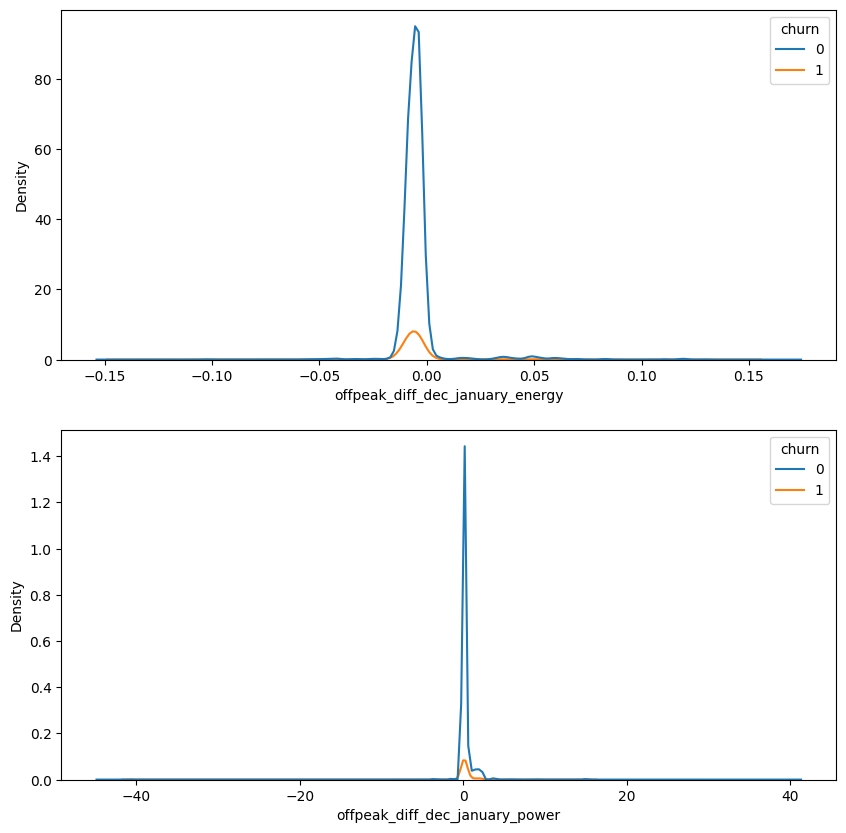

In [56]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
sns.kdeplot(data=df_2, x = 'offpeak_diff_dec_january_energy', hue='churn', ax=ax[0])
sns.kdeplot(data=df_2, x = 'offpeak_diff_dec_january_power', hue='churn', ax=ax[1])

In [66]:
corr_power_churn = np.corrcoef(df_2['churn'], df_2['offpeak_diff_dec_january_power'])[0,1]
corr_energy_churn = np.corrcoef(df_2['churn'], df_2['offpeak_diff_dec_january_energy'])[0,1]

print(f'Correlation between churn and dec/jan off peak power difference: {corr_power_churn}')
print(f'Correlation between churn and dec/jan off peak energy difference: {corr_energy_churn}')

Correlation between churn and dec/jan off peak power difference: 0.0026715299322503817
Correlation between churn and dec/jan off peak energy difference: -0.0010644314844720328


### Percentual difference between last month consumption and mean consumption in the last 12 months

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              14606 non-null  object        
 1   channel_sales                   14606 non-null  object        
 2   cons_12m                        14606 non-null  int64         
 3   cons_gas_12m                    14606 non-null  int64         
 4   cons_last_month                 14606 non-null  int64         
 5   date_activ                      14606 non-null  datetime64[ns]
 6   date_end                        14606 non-null  datetime64[ns]
 7   date_modif_prod                 14606 non-null  datetime64[ns]
 8   date_renewal                    14606 non-null  datetime64[ns]
 9   forecast_cons_12m               14606 non-null  float64       
 10  forecast_cons_year              14606 non-null  int64         
 11  fo

In [18]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  193002 non-null  object        
 1   price_date          193002 non-null  datetime64[ns]
 2   price_off_peak_var  193002 non-null  float64       
 3   price_peak_var      193002 non-null  float64       
 4   price_mid_peak_var  193002 non-null  float64       
 5   price_off_peak_fix  193002 non-null  float64       
 6   price_peak_fix      193002 non-null  float64       
 7   price_mid_peak_fix  193002 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 11.8+ MB


- Diferença de valor dos três últimos meses (quando teve o maior aumento)
- Relação percentual entre o consumo no último mês e o consumo nos últimos 12 meses (ou entre o último trimestre e últimos 12 meses)
- Iferença entre forecast 12m e consumo 12m (tentar verificar os que tiveram maiores diferenças)
- participação do preço fora-ponta no consumo total